# Import needed modules

In [1]:
import os
import time
import shutil
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create needed functions

#### Function to Create Data Frame from Dataset

In [2]:
# Generate data paths with lables 
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels



def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Split data into train, validation, and test
def split_data(tr_dir):
    
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
    
  
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)
    
    return train_df, valid_df, test_df 

#### Function to generate images from dataframe

In [3]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    # define model parameters
    img_size = (224, 224)
    channels = 3 
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    
    def scalar(img):
        return img
    
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size) 
    
    
    return train_gen, valid_gen, test_gen

#### Function to display data sample

In [4]:
def show_images(gen):
    
    g_dict = gen.class_indices       
    classes = list(g_dict.keys())    
    images, labels = next(gen)       
    
    
    length = len(labels)        
    sample = min(length, 25)    
    
    plt.figure(figsize= (20, 20))
    
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]   
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

Declaring callbacks

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience 
        self.stop_patience = stop_patience 
        self.threshold = threshold 
        self.factor = factor 
        self.batches = batches 
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch 

        # callback variables
        self.count = 0 
        self.stop_count = 0
        self.best_epoch = 1   
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) 
        self.highest_tracc = 0.0 
        self.lowest_vloss = np.inf 
        self.best_weights = self.model.get_weights() 
        self.initial_weights = self.model.get_weights() 

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):       
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights) 


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100 
        loss = logs.get('loss')
        
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') 


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) #
        current_lr = lr
        acc = logs.get('accuracy')  
        v_acc = logs.get('val_accuracy') 
        loss = logs.get('loss') 
        v_loss = logs.get('val_loss')  

        if acc < self.threshold: 
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: 
                self.highest_tracc = acc 
                self.best_weights = self.model.get_weights()
                self.count = 0 
                self.stop_count = 0 
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1 
            else:

                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 

        else: 
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: 
                self.lowest_vloss = v_loss 
                self.best_weights = self.model.get_weights() 
                self.count = 0 
                self.stop_count = 0
                self.best_epoch = epoch + 1 
            else: 
                if self.count >= self.patience - 1: 
                    lr = lr * self.factor 
                    self.stop_count = self.stop_count + 1 
                    self.count = 0 
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                else:
                    self.count = self.count + 1 
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: 
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

#         else:
#             if self.ask_epoch != None and self.ask_permission != 0:
#                 if epoch + 1 >= self.ask_epoch:
#                     msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
#                     print(msg)
#                     ans = input('')
#                     if ans == 'H' or ans == 'h':
#                         msg = f'training has been halted at epoch {epoch + 1} due to user input'
#                         print(msg)
#                         self.model.stop_training = True # stop training
#                     else:
#                         try:
#                             ans = int(ans)
#                             self.ask_epoch += ans
#                             msg = f' training will continue until epoch ' + str(self.ask_epoch)
#                             print(msg)
#                             msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
#                             print(msg)
#                         except:
#                             print('Invalid')

#### Function to plot history of training

In [25]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout
#     plt.savefig('performance.png')
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.savefig('performance_1.png')
    plt.show()


#### Function to create Confusion Matrix

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Model Structure

#### Start Reading Dataset

Found 8325 validated image filenames belonging to 10 classes.
Found 1041 validated image filenames belonging to 10 classes.
Found 1041 validated image filenames belonging to 10 classes.


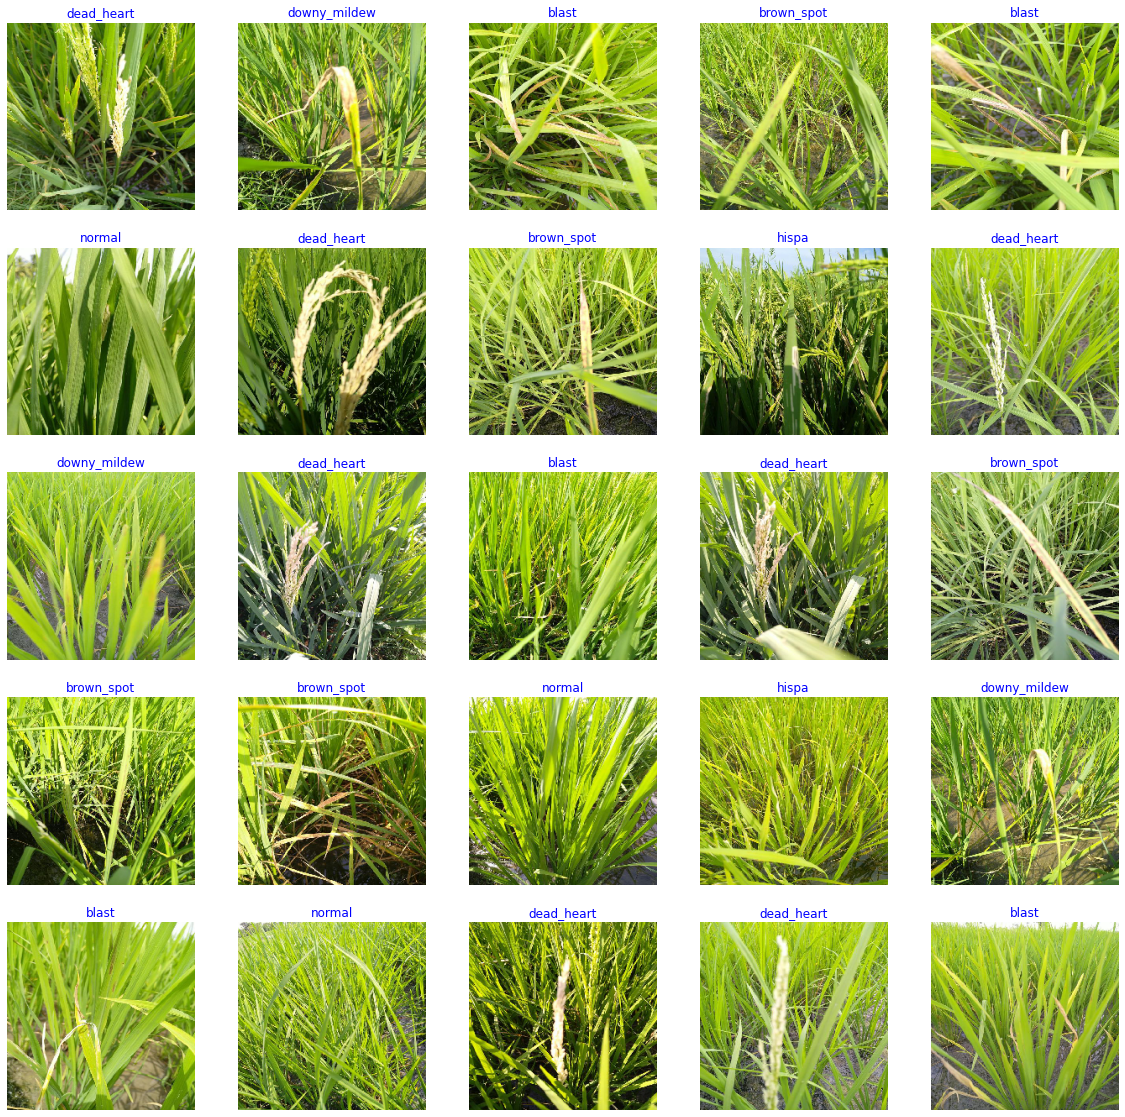

In [8]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/rice-disease-detection/train_images'
train_df, valid_df, test_df = split_data(data_dir)


batch_size = 40
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)


show_images(train_gen)

# EfficientNetB3

#### Generic Model Creation

In [9]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) 


base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43950080/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 11,185,721
Trainable params: 11,095,346
Non-trainable params: 90,375
_________________________________________________________________


In [27]:
len(base_model.layers)

385

#### Set Callback Parameters

In [10]:
batch_size = 40     
epochs = 20        
patience = 1 
stop_patience = 3 
threshold = 0.9 
factor = 0.5 
ask_epoch = 5
batches = int(np.ceil(len(train_gen.labels) / batch_size))  

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

#### Train model

In [11]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /20     7.464   60.649   5.81385  73.007   0.00100  0.00100  accuracy     0.00    139.52 
 2 /20     4.313   87.796   3.29308  92.219   0.00100  0.00100  accuracy    44.76    111.92 
 3 /20     2.658   94.090   2.06903  95.389   0.00100  0.00100  val_loss    37.17    111.72 
 4 /20     1.668   96.937   1.33179  96.158   0.00100  0.00100  val_loss    35.63    111.57 
 5 /20     1.104   97.706   0.91773  96.542   0.00100  0.00100  val_loss    31.09    111.62 
 6 /20     0.781   98.486   0.69886  96.254   0.00100  0.00100  val_loss    23.85    107.44 
 7 /20     0.584   98.763   0.56579  96.254   0.00100  0.00100  val_loss    19.04    111.47 
 8 /20     0.467   98.763   0.46085  96.542   0.00100  0.00100  val_loss    18.55    112.53 
 9 /20     0.383   99.003   0.40054  96.542   0.00100  0.00100  val_loss    13.09    114.34 
10 /20     0.335   99.027   0.37955  95.869   0.00100  0.00100  val_los

#### Display model performance

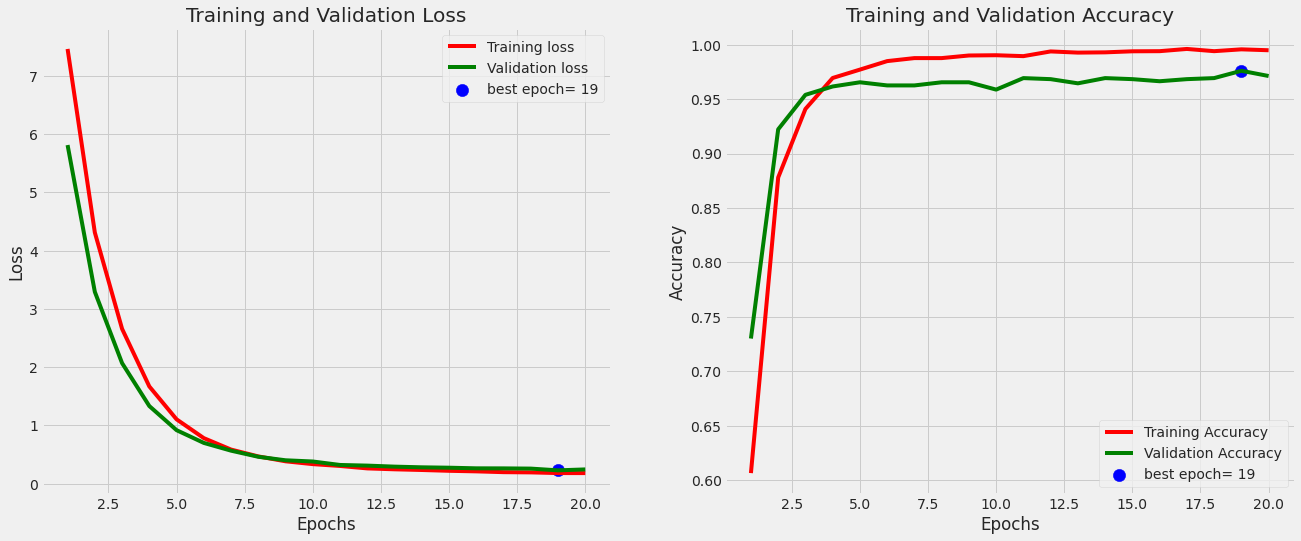

In [26]:
plot_training(history)

### Evaluate model

In [13]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

347/347 [==============================] - 14s 41ms/step - loss: 0.2479 - accuracy: 0.9760
Train Loss:  0.14400523900985718
Train Accuracy:  0.9995195269584656
--------------------
Validation Loss:  0.2276940494775772
Validation Accuracy:  0.9759846329689026
--------------------
Test Loss:  0.24785131216049194
Test Accuracy:  0.9759846329689026


In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[5 9 2 ... 8 5 8]


Confusion Matrix, Without Normalization
[[ 46   0   0   1   1   0   0   0   0   0]
 [  0  38   0   0   0   0   0   0   0   0]
 [  0   0  31   0   0   0   0   0   2   0]
 [  0   0   0 168   2   0   0   0   2   2]
 [  1   0   0   0  93   0   0   0   2   1]
 [  0   0   1   0   0 143   0   0   0   0]
 [  0   0   0   0   2   0  60   0   0   0]
 [  0   0   0   0   0   0   0 159   1   0]
 [  0   0   0   0   0   0   0   4 172   0]
 [  1   0   0   0   0   0   1   1   0 106]]
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.96      0.96      0.96        48
   bacterial_leaf_streak       1.00      1.00      1.00        38
bacterial_panicle_blight       0.97      0.94      0.95        33
                   blast       0.99      0.97      0.98       174
              brown_spot       0.95      0.96      0.95        97
              dead_heart       1.00      0.99      1.00       144
            downy_mildew       0.98      0.97      0.98        62


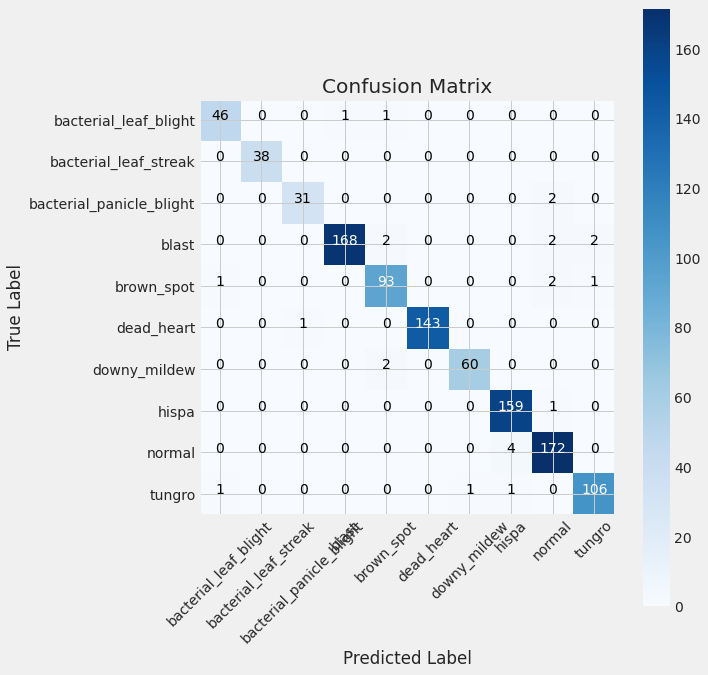

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

### Save model

In [ ]:
model_name = model.input_names[0][:-6]
subject = 'rldd'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

### Generate CSV files containing classes indicies & image size 

In [ ]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')